<font color='tomato'><font color="#CC3D3D"><p>
# AutoEncoder
* Applying Autoencoder to reduce the number of features

<img align='left' src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" width=700 height=500>

#### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from IPython.display import Image
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

print(tf.__version__)

2.3.1


Using TensorFlow backend.


#### Make DNN output reproducible

In [2]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


### Read Data

In [3]:
tr_train = pd.read_csv('X_train.csv', encoding='cp949')
tr_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').age
IDtest = tr_test.custid.unique()

tr_train.head()

,custid,sales_month,sales_day,sales_dayofweek,sales_time,str_nm,goodcd,brd_nm,corner_nm,pc_nm,part_nm,team_nm,buyer_nm,import_flg,tot_amt,dis_amt,net_amt,inst_mon,inst_fee
0,0,6,25,일,1212,무역점,2116050008000,에스티로더,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,90000,9000,81000,3,0
1,0,6,25,일,1242,무역점,4125440008000,시슬리,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,39000,3900,35100,1,0
2,0,8,26,토,1810,본점,2116052008000,크리니크,수입종합화장품,화장품,잡화파트,잡화가용팀,화장품,1,175000,17500,157500,3,0
3,0,8,26,토,1830,본점,4106430119900,듀퐁,수입의류,명품토탈,잡화파트,잡화가용팀,수입명품,1,455000,45500,409500,3,0
4,0,9,3,일,1802,무역점,2139141008000,랑콤,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,0,100000,10000,90000,3,0


### Make BOW-based Features

In [4]:
features = ['brd_nm']

tr_all = pd.concat([tr_train, tr_test])
train = []
test = []

for f in features:
    for d,q in zip([train, test], ['custid not in @IDtest', 'custid in @IDtest']):
        d.append(pd.pivot_table(tr_all, index='custid', columns=f, values='tot_amt',
                                aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0)                 
                 .reset_index()
                 .query(q)
                 .drop(columns=['custid']).values)
 
train, test = np.hstack(train),  np.hstack(test)

train.shape, test.shape

((21587, 1873), (14380, 1873))

### Reduce Dimensionality using Autoencoder

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1873)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               959488    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

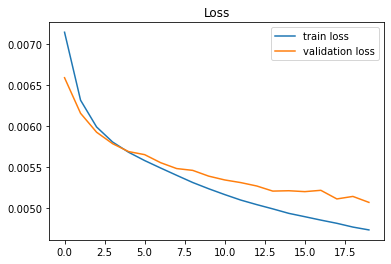

In [5]:
# Define the number of features
max_features = train.shape[1]

# Define the encoder dimension
encoding_dim = 128

# Input Layer
input_dim = keras.Input(shape = (max_features, ))

# Encoder Layers
noise = keras.layers.Dropout(0.5)(input_dim) # for Denoising
encoded1 = keras.layers.Dense(512, activation = 'relu')(input_dim)
encoded2 = keras.layers.Dense(256, activation = 'relu')(encoded1)
encoded3 = keras.layers.Dense(128, activation = 'relu')(encoded2)
encoded4 = keras.layers.Dense(encoding_dim, activation = 'relu')(encoded3)

# Decoder Layers
decoded1 = keras.layers.Dense(128, activation = 'relu')(encoded4)
decoded2 = keras.layers.Dense(256, activation = 'relu')(decoded1)
decoded3 = keras.layers.Dense(512, activation = 'relu')(decoded2)
decoded4 = keras.layers.Dense(max_features, activation = 'linear')(decoded3)

# Combine Encoder and Deocder layers
autoencoder = keras.Model(inputs = input_dim, outputs = decoded4)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse')

# Train the model
history = autoencoder.fit(train, train, epochs=20, batch_size=64, 
                          shuffle=True, validation_data=(test,test))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [6]:
# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [encoded4]
for ix, act in enumerate(hidden_act):
    model = keras.Model(inputs=input_dim, outputs=act)
    if ix == 0: 
        X_train = model.predict(train)
        X_test = model.predict(test)
    else:
        X_train = np.hstack([X_train, model.predict(train)])
        X_test = np.hstack([X_test, model.predict(test)])
        
X_train.shape, X_test.shape

((21587, 128), (14380, 128))

### Build Models

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
____________________________________________________

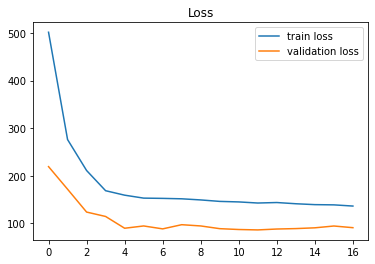

In [7]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
input = keras.Input(shape = (max_features, ))
x = keras.layers.Dense(32, activation='relu')(input)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=input, outputs=output)
model.summary()

# Train the Model
model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Make Submissions

In [8]:
pred = model.predict(X_test).flatten()
t = pd.Timestamp.now()
fname = f"AE_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(pred, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'AE_submission_06042056.csv' is ready to submit.


<font color='blue'><p>
### 추가 고려사항
- Denoising Autoencoder (DAE)가 더 성능이 좋다고 알려져 있음   
- DAE 구현방식  
    
<img align='left' src='https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile24.uf.tistory.com%2Fimage%2F992860505BDC99320A2AA2'>  

<font color='tomato'><font color="#CC3D3D"><p>
# End